# Foundation Models para Dados Tabulares
## Comparacao Completa: XGBoost vs TabPFN

Inclui: ROC-AUC, PR-AUC e **Analise de Custo**

In [1]:
import sys
sys.path.insert(0, '../src')

import os
# Configure HF_TOKEN se necessario

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, average_precision_score

from credit_scoring.data.loader import load_german_credit
from credit_scoring.models.train import load_model
from credit_scoring.models.cost_analysis import comprehensive_evaluation, print_cost_report, plot_profit_curve

print("Setup completo!")

Setup completo!


In [2]:
X, y = load_german_credit(save_raw=False)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Treino: {len(X_train)} | Teste: {len(X_test)}")
print(f"Balanceamento: {y_test.value_counts(normalize=True).to_dict()}")

Treino: 800 | Teste: 200
Balanceamento: {0: 0.7, 1: 0.3}


---
## 1. XGBoost (Baseline)

In [3]:
xgb_model = load_model('../models/best_model_optuna.joblib')
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]
xgb_pred = xgb_model.predict(X_test)

# Avaliacao completa
xgb_eval = comprehensive_evaluation(y_test.values, xgb_proba, 'XGBoost')

xgb_metrics = {
    'Model': 'XGBoost (Optuna)',
    'ROC-AUC': xgb_eval['roc_auc'],
    'PR-AUC': xgb_eval['pr_auc'],
    'F1-Score': f1_score(y_test, xgb_pred),
    'Optimal Threshold': xgb_eval['optimal_threshold'],
    'Profit (Optimal)': xgb_eval['profit_optimal_thresh'],
    'Interpretable': 'Sim (SHAP)'
}

print(f"XGBoost - ROC-AUC: {xgb_metrics['ROC-AUC']:.4f} | PR-AUC: {xgb_metrics['PR-AUC']:.4f}")

XGBoost - ROC-AUC: 0.8058 | PR-AUC: 0.6328


---
## 2. TabPFN (Foundation Model)

In [4]:
from tabpfn import TabPFNClassifier

# Preprocessar
X_train_p = xgb_model.named_steps['preprocessor'].transform(X_train)
X_test_p = xgb_model.named_steps['preprocessor'].transform(X_test)

print("Inicializando TabPFN...")
tabpfn = TabPFNClassifier()
tabpfn.fit(X_train_p, y_train)

tabpfn_proba = tabpfn.predict_proba(X_test_p)[:, 1]
tabpfn_pred = tabpfn.predict(X_test_p)

# Avaliacao completa
tabpfn_eval = comprehensive_evaluation(y_test.values, tabpfn_proba, 'TabPFN')

tabpfn_metrics = {
    'Model': 'TabPFN',
    'ROC-AUC': tabpfn_eval['roc_auc'],
    'PR-AUC': tabpfn_eval['pr_auc'],
    'F1-Score': f1_score(y_test, tabpfn_pred),
    'Optimal Threshold': tabpfn_eval['optimal_threshold'],
    'Profit (Optimal)': tabpfn_eval['profit_optimal_thresh'],
    'Interpretable': 'Limitada'
}

print(f"TabPFN - ROC-AUC: {tabpfn_metrics['ROC-AUC']:.4f} | PR-AUC: {tabpfn_metrics['PR-AUC']:.4f}")

Inicializando TabPFN...


TabPFN - ROC-AUC: 0.8142 | PR-AUC: 0.6683


---
## 3. Comparacao Completa

In [5]:
results = [xgb_metrics, tabpfn_metrics]
comparison_df = pd.DataFrame(results)

print("\n" + "=" * 80)
print("COMPARACAO COMPLETA: XGBoost vs TabPFN")
print("=" * 80)
print(comparison_df.to_string(index=False))


COMPARACAO COMPLETA: XGBoost vs TabPFN
           Model  ROC-AUC   PR-AUC  F1-Score  Optimal Threshold  Profit (Optimal) Interpretable
XGBoost (Optuna) 0.805833 0.632799  0.657534               0.45             -9500    Sim (SHAP)
          TabPFN 0.814167 0.668328  0.576923               0.20            -10200      Limitada


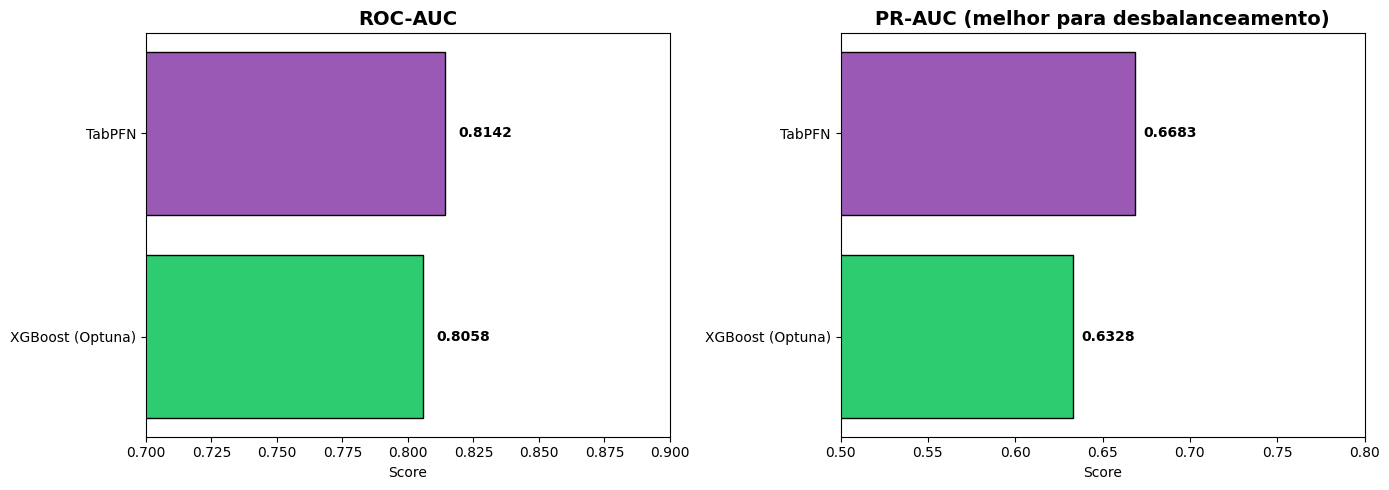

In [6]:
# Visualizacao: ROC-AUC vs PR-AUC
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = comparison_df['Model'].tolist()
colors = ['#2ecc71', '#9b59b6']

# ROC-AUC
ax1 = axes[0]
bars1 = ax1.barh(models, comparison_df['ROC-AUC'], color=colors, edgecolor='black')
for bar, score in zip(bars1, comparison_df['ROC-AUC']):
    ax1.text(score + 0.005, bar.get_y() + bar.get_height()/2, f'{score:.4f}', va='center', fontweight='bold')
ax1.set_xlabel('Score')
ax1.set_title('ROC-AUC', fontsize=14, fontweight='bold')
ax1.set_xlim(0.70, 0.90)

# PR-AUC
ax2 = axes[1]
bars2 = ax2.barh(models, comparison_df['PR-AUC'], color=colors, edgecolor='black')
for bar, score in zip(bars2, comparison_df['PR-AUC']):
    ax2.text(score + 0.005, bar.get_y() + bar.get_height()/2, f'{score:.4f}', va='center', fontweight='bold')
ax2.set_xlabel('Score')
ax2.set_title('PR-AUC (melhor para desbalanceamento)', fontsize=14, fontweight='bold')
ax2.set_xlim(0.50, 0.80)

plt.tight_layout()
plt.savefig('../reports/figures/foundation_models_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 4. Analise de Custo

In [7]:
print("\n" + "=" * 80)
print("ANALISE DE CUSTO - XGBoost")
print("=" * 80)
print_cost_report(y_test.values, xgb_proba, 'XGBoost')


ANALISE DE CUSTO - XGBoost
COST-SENSITIVE EVALUATION: XGBoost

--- Cost Matrix ---
  TN Profit (good customer approved):  R$     50
  TP Profit (bad customer rejected):   R$    100
  FP Cost (good customer rejected):    R$   -200
  FN Cost (bad customer approved):     R$  -1000

--- Performance Metrics ---
  ROC-AUC:  0.8058
  PR-AUC:   0.6328

--- Profit Analysis ---
  Threshold 0.50: R$   -9,700
  Threshold 0.45: R$   -9,500
  Improvement:    R$      200 (+2.1%)

--- Recommendation ---
  Use threshold 0.45 to maximize profit
  Approval rate at optimal: 52.0%


In [8]:
print("\n" + "=" * 80)
print("ANALISE DE CUSTO - TabPFN")
print("=" * 80)
print_cost_report(y_test.values, tabpfn_proba, 'TabPFN')


ANALISE DE CUSTO - TabPFN
COST-SENSITIVE EVALUATION: TabPFN

--- Cost Matrix ---
  TN Profit (good customer approved):  R$     50
  TP Profit (bad customer rejected):   R$    100
  FP Cost (good customer rejected):    R$   -200
  FN Cost (bad customer approved):     R$  -1000

--- Performance Metrics ---
  ROC-AUC:  0.8142
  PR-AUC:   0.6683

--- Profit Analysis ---
  Threshold 0.50: R$  -23,500
  Threshold 0.20: R$  -10,200
  Improvement:    R$   13,300 (+56.6%)

--- Recommendation ---
  Use threshold 0.20 to maximize profit
  Approval rate at optimal: 42.5%


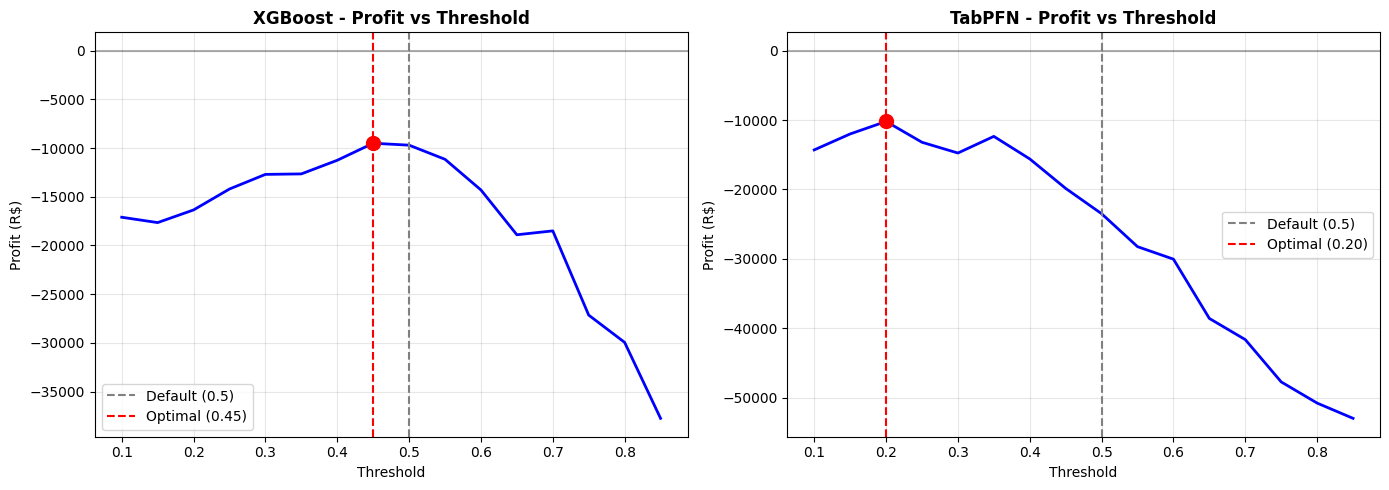

In [9]:
# Curvas de lucro lado a lado
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

from credit_scoring.models.cost_analysis import find_optimal_threshold_by_profit

for ax, (name, proba) in zip(axes, [('XGBoost', xgb_proba), ('TabPFN', tabpfn_proba)]):
    opt_thresh, max_profit, df = find_optimal_threshold_by_profit(y_test.values, proba)
    
    ax.plot(df['threshold'], df['total_profit'], 'b-', linewidth=2)
    ax.axvline(x=0.5, color='gray', linestyle='--', label='Default (0.5)')
    ax.axvline(x=opt_thresh, color='red', linestyle='--', label=f'Optimal ({opt_thresh:.2f})')
    ax.scatter([opt_thresh], [max_profit], color='red', s=100, zorder=5)
    ax.axhline(y=0, color='black', alpha=0.3)
    
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Profit (R$)')
    ax.set_title(f'{name} - Profit vs Threshold', fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/profit_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Conclusao

In [10]:
print("=" * 80)
print("CONCLUSAO FINAL")
print("=" * 80)

# Determinar vencedor por metrica
best_roc = comparison_df.loc[comparison_df['ROC-AUC'].idxmax(), 'Model']
best_pr = comparison_df.loc[comparison_df['PR-AUC'].idxmax(), 'Model']
best_profit = comparison_df.loc[comparison_df['Profit (Optimal)'].idxmax(), 'Model']

print(f"\nMelhor ROC-AUC:    {best_roc}")
print(f"Melhor PR-AUC:     {best_pr}")
print(f"Maior Lucro:       {best_profit}")

print("\n" + "-" * 40)
print("RECOMENDACAO:")
print("-" * 40)
print("- Producao (regulado): XGBoost + SHAP")
print("- Prototipo/PoC:       TabPFN")
print("- Ensemble:            Combinar ambos")

# Salvar
comparison_df.to_csv('../reports/foundation_models_comparison.csv', index=False)
print("\nSalvo em: reports/foundation_models_comparison.csv")

CONCLUSAO FINAL

Melhor ROC-AUC:    TabPFN
Melhor PR-AUC:     TabPFN
Maior Lucro:       XGBoost (Optuna)

----------------------------------------
RECOMENDACAO:
----------------------------------------
- Producao (regulado): XGBoost + SHAP
- Prototipo/PoC:       TabPFN
- Ensemble:            Combinar ambos

Salvo em: reports/foundation_models_comparison.csv
